In [2]:
import json
import os
from PIL import Image


import numpy as np
from PIL import Image
import torch

from colpali_engine.models import ColQwen2, ColQwen2Processor

In [3]:
model = ColQwen2.from_pretrained(
        "vidore/colqwen2-v0.1",
        torch_dtype=torch.bfloat16,
        device_map="cuda:0",  # or "mps" if on Apple Silicon
    ).eval()
processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v0.1")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
article_id = "2305.00379"
img_dir = f"cache/pdf2img/{article_id}"
img_fnames = [x for x in os.listdir(img_dir) if "png" in x]
print(img_fnames)

['0.png', '1.png', '2.png', '3.png', '4.png']


## Embed Images

In [5]:
## Load Images
images = [
	Image.open(os.path.join(img_dir, fname))
	for fname in img_fnames
]
print(len(images))

5


In [6]:
image_embeddings = []
batch_size = 8
with torch.no_grad():
	for i in range(0, len(images), batch_size):
		images_batch = images[i:i+batch_size]
		batch_images = processor.process_images(images_batch).to(model.device)
		batch_image_embeddings = model(**batch_images)
		print(batch_image_embeddings.shape)
		image_embeddings.append(batch_image_embeddings)
		# break
image_embeddings = torch.cat(image_embeddings, dim=0)
print(image_embeddings.shape)

torch.Size([5, 755, 128])
torch.Size([5, 755, 128])


## Embed Query

In [7]:
queries = ["Explain the overall proposed architecture"]
batch_queries = processor.process_queries(queries).to(model.device)

In [8]:
with torch.no_grad():
    # image_embeddings = model(**batch_images)
    query_embeddings = model(**batch_queries)
print(query_embeddings.shape)

torch.Size([1, 28, 128])


## Run Retrieval

In [9]:
scores = processor.score_multi_vector(query_embeddings, image_embeddings)

In [10]:
scores_np = scores[0].numpy()
np.argsort(-scores_np)

array([1, 2, 0, 3, 4])

## Check retrieved image

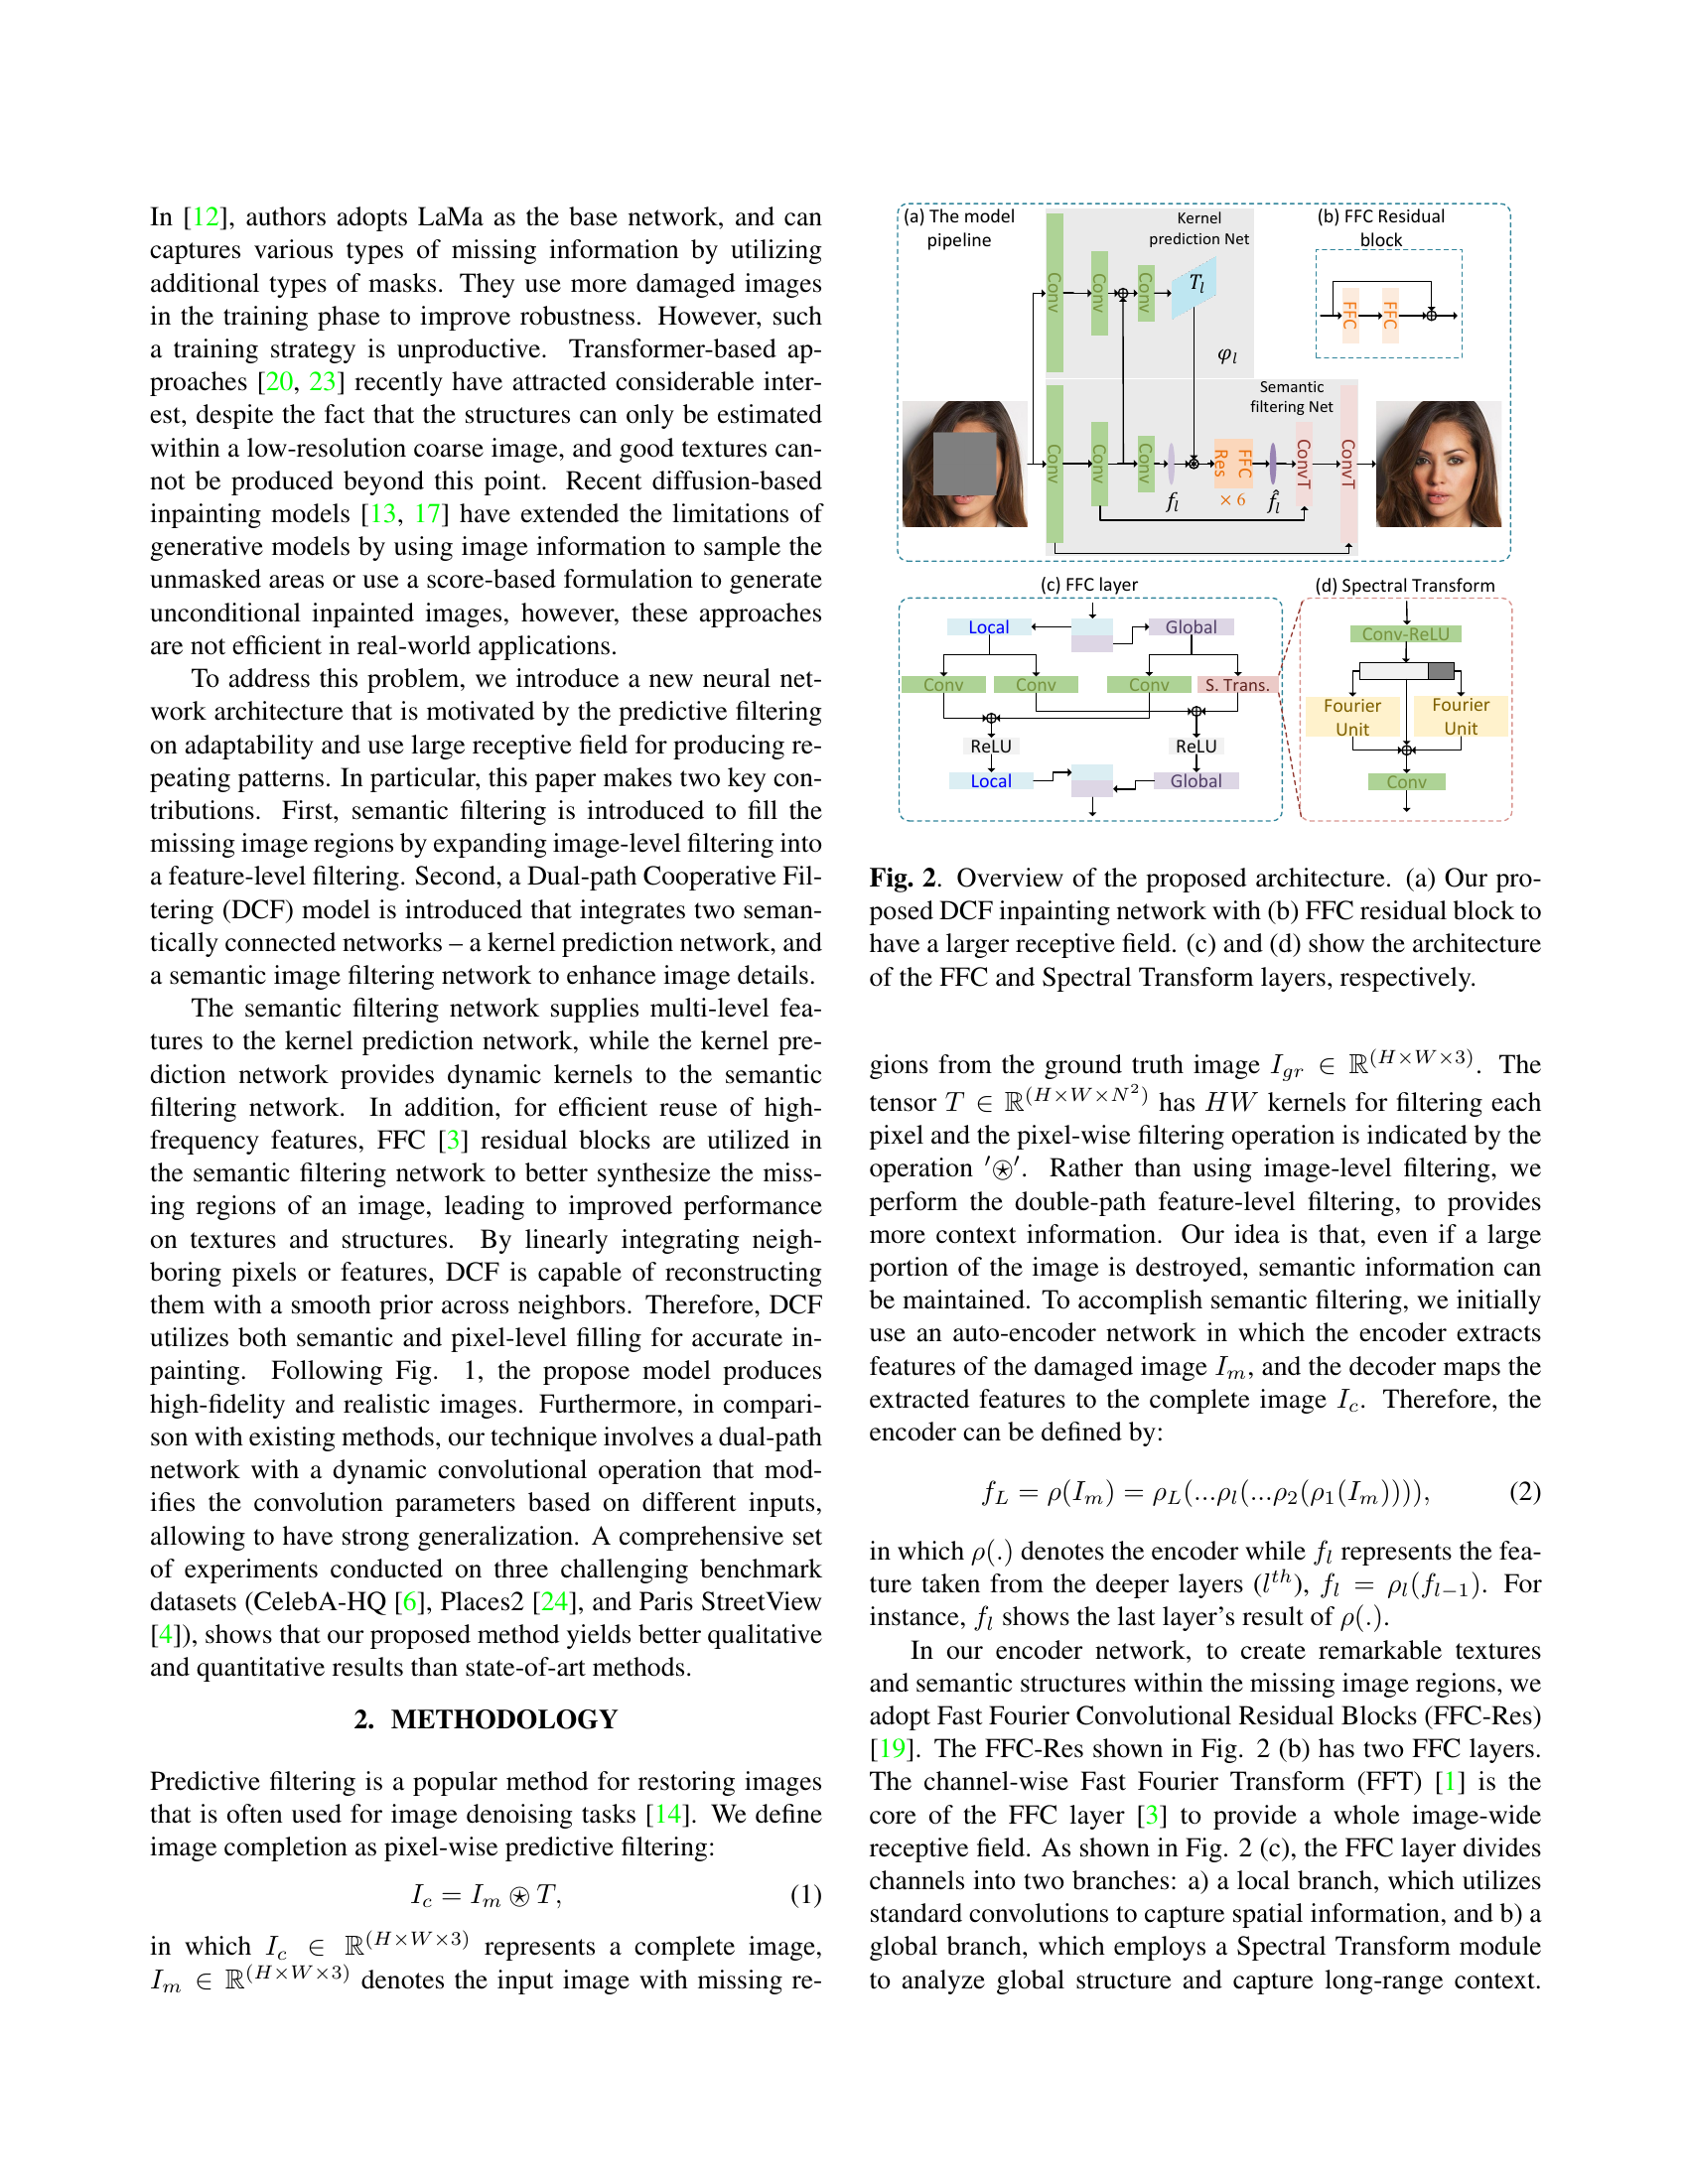

In [11]:
img_id = 1
image = images[img_id]
display(image)